In [2]:
# Import Libs

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator

In [ ]:
# Define QNetwork class with varible num of hidden neurons & hidden layers (we need this later)

state_size = 2  # 2 Dims state matrix
action_size = 4  # Num actions: up, down, left, right

# Init QNetwork class
class QNetwork(nn.Module):
    def __init__(self, state_size = state_size, action_size = action_size, hidden_neurons = 24, hidden_layers = 1):
        super(QNetwork, self).__init__()

        # Input layer
        self.layers = [nn.Linear(state_size, hidden_neurons)]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_neurons, hidden_neurons))

        # Output layer
        self.layers.append(nn.Linear(hidden_neurons, action_size))

        # And whole model
        self.model = nn.Sequential(*self.layers)


    def forward(self, x):
        # Apply ReLU activation to each hidden layer
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))

        # Output layer
        x = self.layers[-1](x)
        return x

In [43]:
# Define Environment class (5x5 matrix with 3 obstacles, wxit & agent)

class SimpleEnv():
    def __init__(self, grid_size = (5, 5)):
        self.grid_size = grid_size
        self.state_space_size = np.prod(grid_size)
        self.action_space_size = 4
        self.agent_position = None
        self.goal_position = None
        self.obstacle_positions = None
        self.max_steps = 10
        self.steps_taken = 0
        self.initialize_positions()


    def initialize_positions(self):
        self.agent_position = (self.grid_size[0] - 1, self.grid_size[1] - 1)
        self.goal_position = (0, 0)
        self.obstacle_positions = ((2, 2), (self.grid_size[0] - 1, 0), (0, self.grid_size[1] - 1))
        self.steps_taken = 0


    def step(self, action):
        reward = 0

        if action == 0:  # Go up
            self.agent_position = (self.agent_position[0] - 1, self.agent_position[1])
        elif action == 1:  # Go down
            self.agent_position = (self.agent_position[0] + 1, self.agent_position[1])
        elif action == 2:  # Go left
            self.agent_position = (self.agent_position[0], self.agent_position[1] - 1)
        elif action == 3:  # Go right
            self.agent_position = (self.agent_position[0], self.agent_position[1] + 1)

        # Stay if we try get out of boarders
        self.agent_position = (
            max(0, min(self.agent_position[0], self.grid_size[0] - 1)),
            max(0, min(self.agent_position[1], self.grid_size[1] - 1))
        )

        self.steps_taken += 1

        # If we reach obstacle get penalty with -1000 points
        for i in self.obstacle_positions:
            if self.agent_position == i:
                reward -= 1000


        # If we rich exit get 50 extra points
        if self.agent_position == self.goal_position:
            reward += 50

        # Minus Euglidian distance if we do not rich the exit
        # That means that we will try to get closer to exit each step
        distance = np.linalg.norm(np.array(self.agent_position) - np.array(self.goal_position))
        reward -= distance

        done = self.agent_position == self.goal_position or self.steps_taken == self.max_steps

        return self.agent_position, reward, done


    def reset(self):
        self.initialize_positions()
        return self.agent_position

In [36]:
# Train define function

def train(env, model, episodes = 500, learning_rate = 0.01, gamma = 0.95, verbose = False):
    # Use Adam optimizer with learning_rate
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    best_reward = -np.inf

    for episode in range(episodes):
        state = env.reset()
        done = False

        current_reward = 0

        while not done:
            state_tensor = torch.FloatTensor([state])
            q_values = model(state_tensor)

            _, action_idx = torch.max(q_values, dim = 1)
            action = action_idx.item()

            next_state, reward, done = env.step(action)

            current_reward += reward

            next_state_tensor = torch.FloatTensor([next_state])
            next_q_values = model(next_state_tensor)

            target_q = reward + gamma * torch.max(next_q_values)

            # Change loss function, not the same as in example
            # It is common to use the Huber loss (smooth L1 loss) as the loss function for Q-learning problems.
            loss = F.smooth_l1_loss(q_values[0, action], target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        best_reward = max(best_reward, current_reward)

    if verbose :
        print(f"Finish fitting with {episodes} expochs with best reward: {best_reward}")

    return best_reward

q_network = QNetwork(state_size, action_size)
env = SimpleEnv()
train(env, q_network, verbose = True)

Finish fitting with 500 expochs with best reward: 28.592199219341495


28.592199219341495

In [38]:
# Do test models

def test_model(env, model, num_episodes = 1, verbose = False):
    model.eval()

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor([state])
            q_values = model(state_tensor)

            _, action_idx = torch.max(q_values, dim=1)
            action = action_idx.item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

            if verbose :
                print(f"Episode {episode + 1}, State: {state}, Action: {action}, Reward: {reward}")

        if verbose :
            print(f"Total Reward in Episode {episode + 1}: {total_reward}\n")

    return total_reward


test_model(env, q_network, verbose = True)

Episode 1, State: (4, 3), Action: 2, Reward: -5.0
Episode 1, State: (4, 2), Action: 2, Reward: -4.47213595499958
Episode 1, State: (4, 1), Action: 2, Reward: -4.123105625617661
Episode 1, State: (3, 1), Action: 0, Reward: -3.1622776601683795
Episode 1, State: (3, 0), Action: 2, Reward: -3.0
Episode 1, State: (2, 0), Action: 0, Reward: -2.0
Episode 1, State: (1, 0), Action: 0, Reward: -1.0
Episode 1, State: (0, 0), Action: 0, Reward: 50.0
Total Reward in Episode 1: 27.24248075921438



27.24248075921438

In [39]:
# Visualize model's work in console

def test_model_console_visualization(env, model, episode_num = 10):
    model.eval()

    for episode in range(episode_num):
        state = env.reset()
        done = False
        total_reward = 0

        print(f"Episode {episode + 1}:")

        while not done:
            grid_state = [['O' for _ in range(env.grid_size[1])] for _ in range(env.grid_size[0])] # Free cells
            grid_state[env.goal_position[0]][env.goal_position[1]] = 'G' # For exit
            for i in env.obstacle_positions:
                grid_state[i[0]][i[1]] = 'X' # For obstacles
            grid_state[state[0]][state[1]] = 'A' # For agent

            for row in grid_state:
                print(" ".join(row))
            print("\n")

            state_tensor = torch.FloatTensor([state])
            q_values = model(state_tensor)

            _, action_idx = torch.max(q_values, dim = 1)
            action = action_idx.item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

            print(f"Action: {action}, Reward: {reward}")

        print(f"Total Reward in Episode {episode + 1}: {total_reward}\n")

# Visualize tests in console
test_model_console_visualization(env, q_network, episode_num = 1)

Episode 1:
G O O O X
O O O O O
O O X O O
O O O O O
X O O O A


Action: 2, Reward: -5.0
G O O O X
O O O O O
O O X O O
O O O O O
X O O A O


Action: 2, Reward: -4.47213595499958
G O O O X
O O O O O
O O X O O
O O O O O
X O A O O


Action: 2, Reward: -4.123105625617661
G O O O X
O O O O O
O O X O O
O O O O O
X A O O O


Action: 0, Reward: -3.1622776601683795
G O O O X
O O O O O
O O X O O
O A O O O
X O O O O


Action: 2, Reward: -3.0
G O O O X
O O O O O
O O X O O
A O O O O
X O O O O


Action: 0, Reward: -2.0
G O O O X
O O O O O
A O X O O
O O O O O
X O O O O


Action: 0, Reward: -1.0
G O O O X
A O O O O
O O X O O
O O O O O
X O O O O


Action: 0, Reward: 50.0
Total Reward in Episode 1: 27.24248075921438



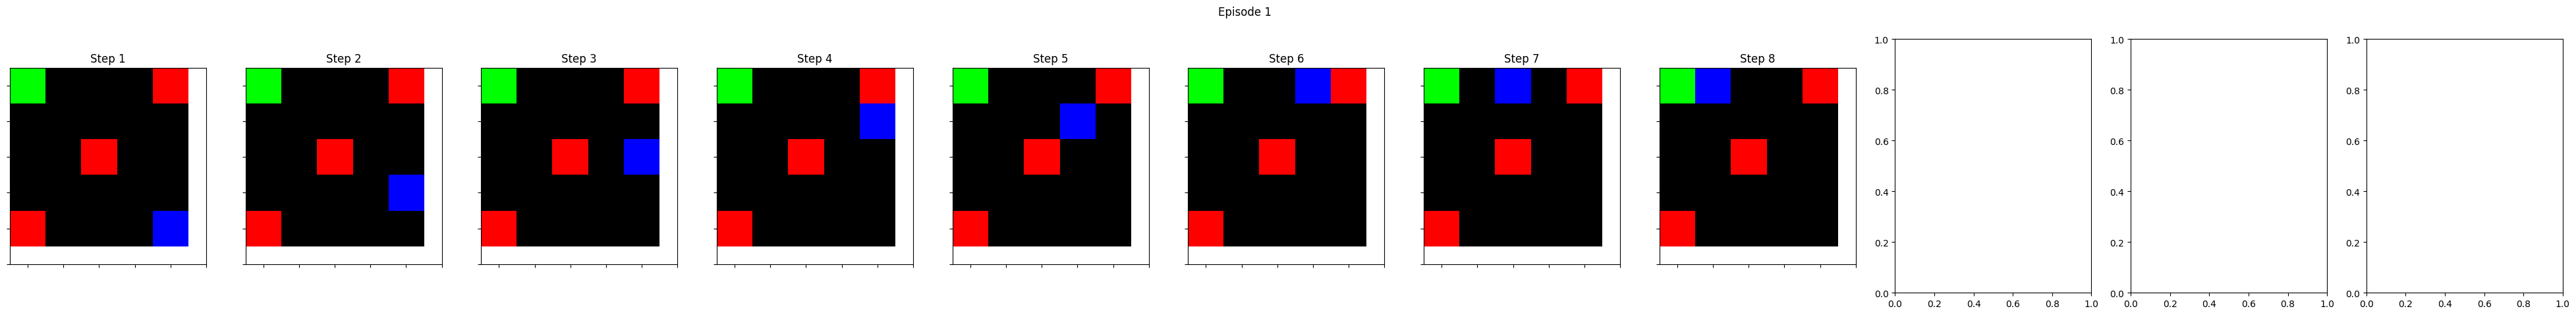

Total Reward in Episode 1: 27.24248075921438



In [31]:
# Visualize states with matplotlib

def visualize_grid_state(ax, env):
    grid_state = np.zeros((env.grid_size[0], env.grid_size[1], 3), dtype = np.uint8)

    grid_state[env.goal_position[0], env.goal_position[1]] = [0, 255, 0]  # Green color for the goal

    for i in env.obstacle_positions:
        grid_state[i[0], i[1]] = [255, 0, 0]  # Red color for obstacles

    grid_state[env.agent_position[0], env.agent_position[1]] = [0, 0, 255]  # Blue color for the agent

    ax.imshow(grid_state)
    ax.set_xticks(range(env.grid_size[1] + 1))
    ax.set_yticks(range(env.grid_size[0] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])


def test_model_graphics_visualization(env, model, episode_num):
    model.eval()

    for episode in range(episode_num):
        state = env.reset()
        done = False
        total_reward = 0

        fig, axs = plt.subplots(1, env.max_steps + 1, figsize = (env.max_steps * 5, 5))
        fig.suptitle(f'Episode {episode + 1}')

        for step, ax in enumerate(axs, start = 1):
            ax.set_title(f'Step {step}')

            visualize_grid_state(ax, env)

            state_tensor = torch.FloatTensor([state])
            q_values = model(state_tensor)

            _, action_idx = torch.max(q_values, dim = 1)
            action = action_idx.item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

            if done:
                break

        plt.show()
        print(f"Total Reward in Episode {episode + 1}: {total_reward}\n")


test_model_graphics_visualization(env, q_network, 1)

In [ ]:
# Define Wrapper class so sklern RandomizedSearchCV can find best param
# So for custom classes we need fit & score functions with soma parameters

class QNetworkWrapper(BaseEstimator):
    def __init__(self, state_size, action_size, hidden_neurons = 24, learning_rate = 0.01, gamma = 0.95, episodes = 500, hidden_layers = 1):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.episodes = episodes
        self.hidden_layers = hidden_layers
        self.model = QNetwork(state_size, action_size, self.hidden_neurons, self.hidden_layers)
        self.env = SimpleEnv()


    def fit(self, X, y):
        return train(self.env, self.model, episodes = self.episodes, learning_rate = self.learning_rate, gamma = self.gamma)


    def score(self, X, y):
        score = test_model(self.env, self.model)
        print(f'Gamma: {self.gamma:.4f}, learning_rate = {self.learning_rate:.4f}, episodes = {self.episodes}, hidden_neurons = {self.hidden_neurons}, hidden_layers = {self.hidden_layers}, score = {score:.4f}')
        return score

In [32]:
# Define the parameter grid for RandomizedSearchCV
# So there are parameters that we can configure
# It includs both model & Environment parameters

param_dist = {
    'learning_rate': np.arange(0.001, 0.02, 0.001),
    'gamma': np.arange(0.9, 0.95, 0.01),
    'episodes' : np.arange(250, 1500, 50),
    'hidden_neurons' : np.arange(2, 50, 1),
    'hidden_layers' : np.arange(1, 5, 1)
}

network_wrapper = QNetworkWrapper(state_size, action_size)

random_search = RandomizedSearchCV(network_wrapper,
                                   param_distributions = param_dist,
                                   n_iter = 25,
                                   cv = 3)

# Fit the model with the data (dummy X and y as they are not used in the training function)
random_search.fit(np.zeros((10, state_size)), np.zeros(10))

# Access the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params, '\n\n\n\n\n')

cv_results = random_search.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Iteration {i+1} - Parameters: {cv_results['params'][i]}, Mean Test Score: {cv_results['mean_test_score'][i]}\n")

Gamma: 0.9400, learning_rate = 0.0030, episodes = 250, hidden_neurons = 32, hidden_layers = 3, score = 27.2425
Gamma: 0.9400, learning_rate = 0.0030, episodes = 250, hidden_neurons = 32, hidden_layers = 3, score = -973.5952
Gamma: 0.9400, learning_rate = 0.0030, episodes = 250, hidden_neurons = 32, hidden_layers = 3, score = -973.5952
Gamma: 0.9300, learning_rate = 0.0060, episodes = 1100, hidden_neurons = 43, hidden_layers = 2, score = 27.2425
Gamma: 0.9300, learning_rate = 0.0060, episodes = 1100, hidden_neurons = 43, hidden_layers = 2, score = -973.5952
Gamma: 0.9300, learning_rate = 0.0060, episodes = 1100, hidden_neurons = 43, hidden_layers = 2, score = 27.2425
Gamma: 0.9300, learning_rate = 0.0040, episodes = 700, hidden_neurons = 47, hidden_layers = 2, score = 27.2425
Gamma: 0.9300, learning_rate = 0.0040, episodes = 700, hidden_neurons = 47, hidden_layers = 2, score = 27.2425
Gamma: 0.9300, learning_rate = 0.0040, episodes = 700, hidden_neurons = 47, hidden_layers = 2, score = 

Finish fitting with 1350 expochs with best reward: 28.52396713186826


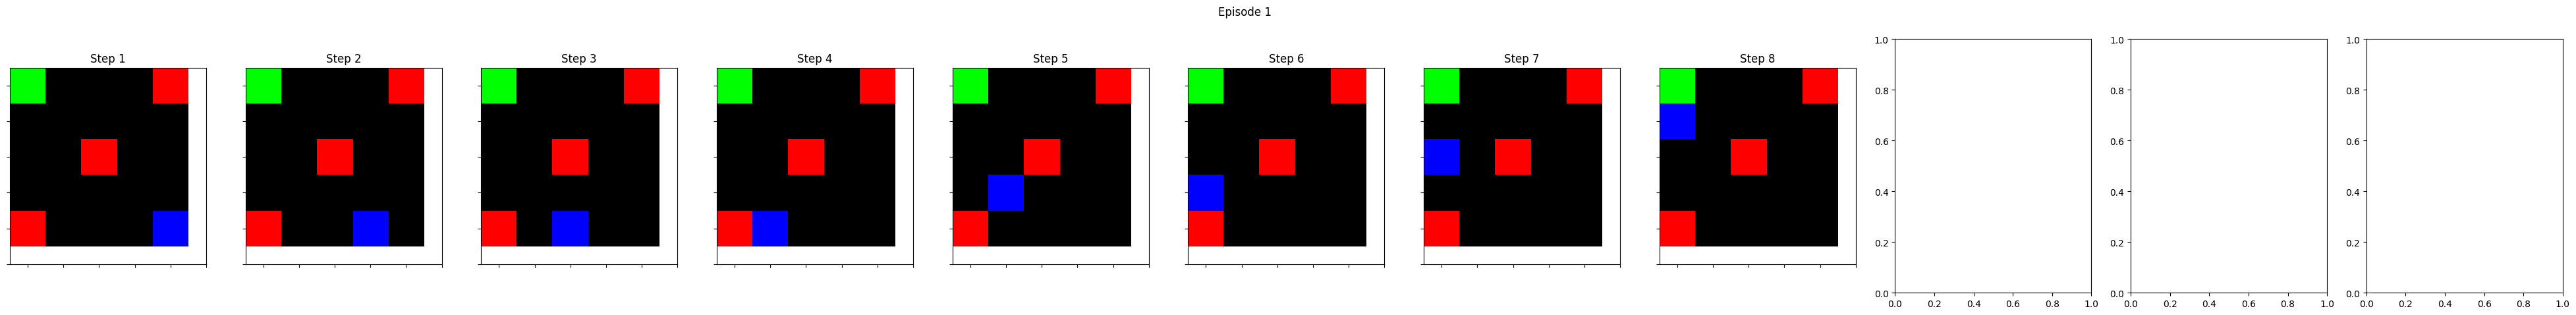

Total Reward in Episode 1: 27.24248075921438



In [33]:
# Show how best model works

best_model = QNetwork(state_size, action_size, hidden_neurons = 31, hidden_layers = 1)
env = SimpleEnv()

train(env, best_model, verbose = True, learning_rate = 0.003, gamma = 0.91, episodes = 1350)

test_model_graphics_visualization(env, best_model, 1)